In [1]:
import cv2
import csv
import os

import torch
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt

from torch.utils.data import Sampler
import random

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import train_test_split

In [2]:
session_epochs = (200, 100, 100)
dataset_sample_size = 0.16

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# This class stores a scan slice image and its associated mask
class ScanSlice:
    def __init__(self, file_path, shape, transform=None):
        self.file_path = file_path
        self.case = file_path.split('/')[-4]
        self.transform = transform
        self.shape = shape
        self.feature_data = None
        self.mask_count = 0

        # format the file name properly
        case_path = file_path.split('/')
        slice_name = case_path[-1].split('_')

        # name is the name in the train.csv file
        # original shape is the shape of the raw image before transform
        self.name = f"{case_path[-3]}_slice_{slice_name[1]}"
        self.original_shape = (int(slice_name[3]), int(slice_name[2]))

        # apply a default mask
        self.mask = np.zeros(self.shape, dtype=np.uint8)

        # init the mask values that we will use
        self.mask_values = {"large_bowel": 1, "small_bowel": 2, "stomach": 3}

    def features(self, device="cpu", dtype=torch.float):
        return self.feature_data

    def decode_rle(self, rle, label):
        # make sure the rle is not empty
        if not rle or (type(rle) is not str and np.isnan(rle)) or rle.strip() == "":
            return

        self.mask_count += 1
        s = list(map(int, rle.strip().split()))
        starts, lengths = s[::2], s[1::2]
        starts = np.array(starts)
        ends = starts + lengths

        mask = np.zeros(self.original_shape[0] * self.original_shape[1], dtype=np.uint8)
        for start, end in zip(starts, ends):
            mask[start:end] = 1

        mask = cv2.resize(mask.reshape(self.original_shape), self.shape, interpolation=cv2.INTER_NEAREST)
        self.mask[mask == 1] = self.mask_values[label]

    def load_slice(self, device="cpu", dtype=torch.float):
                # load image into memory
        img_data = cv2.imread(self.file_path, cv2.IMREAD_UNCHANGED)

        # format the data accordingly
        result = self.transform(img_data)
        result = result.to(dtype=dtype)
        result.to(device)
        self.feature_data = result
        


class MRIData(Dataset):
    def __init__(self, transform, slice_shape, device="cpu", from_scratch=True):
        self.slices = dict()
        self.slice_index = list()
        self.cases = set()
        self.device = device
        self.transform = transform
        self.slice_shape = slice_shape

        self.full = list()
        self.mixed = list()
        self.empty = list()
        if from_scratch:
            self.read_slice_data()
            self.read_rles()

        n_samples = int(len(self.slice_index) * dataset_sample_size)
        self.slice_index = self.slice_index[:n_samples]

        self.slices = dict()
        for sample in self.slice_index:
            self.slices[sample.name] = sample

        
        self.num_samples()
        

    def num_samples(self):
        self.sort_samples()
        for sample in self.slice_index:
            sample.load_slice()
        
        print(f"full samples: {len(self.full)}")
        print(f"mixed samples: {len(self.mixed)}")
        print(f"empty samples: {len(self.empty)}")
        
    def __getitem__(self, idx):
        if type(idx) == str:
            return self.slices[idx].features(device=self.device), self.slices[idx].mask.astype(np.int64)
        return self.slice_index[idx].features(device=self.device), self.slice_index[idx].mask.astype(np.int64)

    def __len__(self):
        return len(self.slices)

    def get_slice(self, idx):
        if type(idx) == str:
            return self.slices[idx]
        return self.slice_index[idx]

    def read_slice_data(self):
        # get all of the slice paths
        slices = glob(f"{os.getcwd()}/gi-tract-data/train/*/*/scans/slice_*")
        slices = [slice.replace("\\", "/") for slice in slices]

        # create a slice object for every slice
        for slice_path in slices:
            ss = ScanSlice(slice_path, self.slice_shape, self.transform)
            self.slice_index.append(ss)
            self.slices[ss.name] = ss

    def read_rles(self):
        # open the train.csv file
        train_csv_path = f"{os.getcwd()}/gi-tract-data/train.csv"
        rle_file = pd.read_csv(train_csv_path)

        # give each slice its rle
        for i in range(0, len(rle_file)):
            slice_name, label, rle = rle_file.iloc[i]
            self.slices[slice_name].decode_rle(rle, label)

    def sort_samples(self):
        for i in range(len(self.slices)):
            sample = self.get_slice(i)
            self.cases.add(sample.case)
            if sample.mask_count == 0:
                self.empty.append(i)
            elif sample.mask_count == 3:
                self.full.append(i)
            else:
                self.mixed.append(i)

    def get_case(self, cases):
        # get the slice names for a case
        case_slices = list()
        #for case in cases:
        for case in cases:
            for slice in self.slice_index:
                if slice.case == case:
                    case_slices.append(slice)
        # create a new dataset with only the slices from this case
        case_dataset = MRIData(self.transform, self.slice_shape, self.device, from_scratch=False)
        for slice in case_slices:
            case_dataset.slices[slice.name] = slice
        case_dataset.slice_index = case_slices
        return case_dataset

    def num_cases(self):
        return len(self.cases)
    
    def slices_per_case(self):
        slice_per_case = dict()
        for case in self.cases:
            slice_per_case[case] = len([slice for slice in self.slice_index if slice.case == case])
        return slice_per_case

    def approximate_percentage(self, percent):
        total = len(self.slice_index)
        slices_per_case = self.slices_per_case()
        
        subset = list()
        subset_size = 0
        for case in self.cases:
            subset_size += slices_per_case[case]
            subset.append(case)
            if subset_size >= total * percent:
                break
        remaining_cases = list(self.cases - set(subset))
        return subset, subset_size / total, remaining_cases, len(self.cases) - len(subset) / total


    def display_image_with_mask(self, idx):
        img, mask = self[idx]
        plt.figure()
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(mask, alpha=0.5)
        plt.axis('off')
        plt.show()

In [5]:
class BatchSampler(Sampler):
    def __init__(self, train_dataset, full, mixed, empty, batch_size, full_count, mixed_count, empty_count):
        self.full = full
        self.mixed = mixed
        self.none = empty
        self.batch_size = batch_size
        self.full_count = full_count
        self.partial_count = mixed_count
        self.none_count = empty_count
        self.dataset_len = len(train_dataset)

    def __iter__(self):
        batch = (
            random.sample(self.full, self.full_count) +
            random.sample(self.mixed, self.partial_count) +
            random.sample(self.none, self.none_count)
        )
        random.shuffle(batch)
        yield batch

    def __len__(self):
        return self.dataset_len // self.batch_size

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

mrid = MRIData(transform, (256, 256), device=device)

full samples: 531
mixed samples: 2301
empty samples: 3327


In [7]:
#Number of slices per case
print(f"Number of slices: {len(mrid)}")
print(f"Number of cases: {mrid.num_cases()}")
print(f"Number of slices per case: {mrid.slices_per_case()}")

Number of slices: 6159
Number of cases: 16
Number of slices per case: {'case11': 432, 'case116': 144, 'case114': 432, 'case118': 368, 'case117': 464, 'case111': 288, 'case107': 432, 'case101': 576, 'case110': 288, 'case113': 720, 'case115': 144, 'case119': 720, 'case121': 432, 'case122': 143, 'case102': 144, 'case108': 432}


In [8]:
train_cases = mrid.approximate_percentage(0.8)
print(f"Approximate percentage: {train_cases[1] * 100:.2f}%")

test_dataset = mrid.get_case(train_cases[2])
mrid = mrid.get_case(train_cases[0])
print(f"Number of training slices: {len(mrid)}")
mrid.num_samples()
print(f"Number of remaining slices: {len(test_dataset)}")
test_dataset.num_samples()

validation_cases = test_dataset.approximate_percentage(0.5)
print(f"Approximate percentage: {validation_cases[1] * 100:.2f}%")
val_dataset = test_dataset.get_case(validation_cases[0])
test_dataset = test_dataset.get_case(validation_cases[2])
print(f"Number of test slices: {len(test_dataset)}")
test_dataset.num_samples()
print(f"Number of val slices: {len(val_dataset)}")
val_dataset.num_samples()

Approximate percentage: 81.31%
full samples: 0
mixed samples: 0
empty samples: 0
full samples: 0
mixed samples: 0
empty samples: 0
Number of training slices: 5008
full samples: 395
mixed samples: 1932
empty samples: 2681
Number of remaining slices: 1151
full samples: 136
mixed samples: 369
empty samples: 646
Approximate percentage: 50.04%
full samples: 0
mixed samples: 0
empty samples: 0
full samples: 0
mixed samples: 0
empty samples: 0
Number of test slices: 575
full samples: 49
mixed samples: 211
empty samples: 315
Number of val slices: 576
full samples: 87
mixed samples: 158
empty samples: 331


In [9]:
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [10]:
def split_indices(indices, train_ratio=0.8, val_ratio=0.10, test_ratio=0.10, seed=42):
    train, temp = train_test_split(indices, test_size=(1 - train_ratio), random_state=seed)
    val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=seed)
    return train, val, test

full_train = mrid.full
partial_train = mrid.mixed
if len(mrid.empty) > 0:
    none_train = mrid.empty
else:
    none_train = list()
train_indices = full_train + partial_train + none_train

train_dataset = Subset(mrid, train_indices)

def get_train_loader_ratio(train_dataset, full_count, mixed_count, empty_count):
    full = list()
    mixed = list()
    empty = list()

    for i in range(len(train_indices)):
        if mrid.get_slice(train_indices[i]).mask_count == 3:
            full.append(i)
        elif mrid.get_slice(train_indices[i]).mask_count == 0:
            empty.append(i)
        else:
            mixed.append(i)
    sampler = BatchSampler(
    train_dataset=train_dataset,
    full=full,
    mixed=mixed,
    empty=empty,
    batch_size=16,
    full_count=full_count,
    mixed_count=mixed_count,
    empty_count=empty_count
    )
    return DataLoader(train_dataset, batch_sampler=sampler)


In [11]:
class DiceLoss(nn.Module):
    """
    Multi‑class Dice loss.
    Expects:
      - logits: (B, C, H, W) raw network outputs
      - targets: (B, H, W) integer class labels in [0..C-1]
    """
    def __init__(self, smooth: float = 1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Number of classes from logits shape
        num_classes = logits.shape[1]

        # Convert to probabilities
        probs = F.softmax(logits, dim=1)

        # One‑hot encode targets to shape (B, C, H, W)
        with torch.no_grad():
            targets_one_hot = F.one_hot(targets, num_classes)  # (B, H, W, C)
            targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # Compute per‑class Dice score
        dims = (0, 2, 3)  # sum over batch & spatial dims
        intersection = torch.sum(probs * targets_one_hot, dims)
        cardinality  = torch.sum(probs + targets_one_hot, dims)
        dice_score   = (2. * intersection + self.smooth) / (cardinality + self.smooth)

        # Dice loss is 1 – mean Dice score across classes
        return 1. - dice_score.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha: float = 0.5, weight: torch.Tensor = None, ignore_index: int = -100):
        super().__init__()
        self.alpha = alpha
        self.ce    = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
        self.dice  = DiceLoss()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        loss_ce   = self.ce(logits, targets)
        loss_dice = self.dice(logits, targets)
        return self.alpha * loss_ce + (1. - self.alpha) * loss_dice

In [12]:
# Define a double convolution block: (Conv -> BatchNorm -> ReLU) * 2
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downsampling block: MaxPool then DoubleConv
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class BottleneckResBlock(nn.Module):
    def __init__(self, in_channels, dropout_prob=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))

# Upsampling block: Upsample (or ConvTranspose2d) then DoubleConv.
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is from the previous layer (decoder), x2 is from the encoder (skip connection)
        x1 = self.up(x1)
        # pad x1 if necessary to match dimensions of x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Final output convolution to reduce the number of channels to the desired number of classes.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
# this reduces memory problems with cuda
torch.cuda.empty_cache()

In [14]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.bottleneck = BottleneckResBlock(1024)
        self.up1 = Up(1536, 512)
        self.up2 = Up(768, 256)
        self.up3 = Up(384, 128)
        self.up4 = Up(192, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.bottleneck(x5)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
model = UNet(n_channels=1, n_classes=4)
model.to(device)

criterion = CombinedLoss(alpha=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = []
    for inputs, targets in val_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss.append(loss.detach())

    batch_losses = torch.stack(val_loss).mean().item()   
    return {'val_loss': batch_losses}

In [17]:


csv_file = open('LeakyReluTrainingData1.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])

train_loader = get_train_loader_ratio(train_dataset, full_count=16, mixed_count=0, empty_count=0)

num_epochs = session_epochs[0]
history = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0
    train_losses = []
    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()


        # Accumulate the loss for this batch.
        train_loss += loss.item() * inputs.size(0)
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    # Compute average training loss.
    #train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {result['train_loss']:.4f} - Val Loss: {result['val_loss']:.4f}")
    csv_writer.writerow([epoch+1, result['train_loss'], result['val_loss']])

csv_file.close()

C:\Users\Josh\AppData\Local\Temp\ipykernel_38296\2459447256.py:31: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  train_loss += loss.item() * inputs.size(0)


Epoch 1/200 - Train Loss: 0.8994 - Val Loss: 0.9159
Epoch 2/200 - Train Loss: 0.8860 - Val Loss: 0.9151
Epoch 3/200 - Train Loss: 0.8696 - Val Loss: 0.9138
Epoch 4/200 - Train Loss: 0.8615 - Val Loss: 0.9122
Epoch 5/200 - Train Loss: 0.8514 - Val Loss: 0.9102
Epoch 6/200 - Train Loss: 0.8367 - Val Loss: 0.9078
Epoch 7/200 - Train Loss: 0.8305 - Val Loss: 0.9052
Epoch 8/200 - Train Loss: 0.8321 - Val Loss: 0.9024
Epoch 9/200 - Train Loss: 0.8111 - Val Loss: 0.8991
Epoch 10/200 - Train Loss: 0.8117 - Val Loss: 0.8963
Epoch 11/200 - Train Loss: 0.8040 - Val Loss: 0.8928
Epoch 12/200 - Train Loss: 0.8130 - Val Loss: 0.8906
Epoch 13/200 - Train Loss: 0.7906 - Val Loss: 0.8865
Epoch 14/200 - Train Loss: 0.7838 - Val Loss: 0.8823
Epoch 15/200 - Train Loss: 0.7915 - Val Loss: 0.8780
Epoch 16/200 - Train Loss: 0.7907 - Val Loss: 0.8742
Epoch 17/200 - Train Loss: 0.8077 - Val Loss: 0.8725
Epoch 18/200 - Train Loss: 0.7864 - Val Loss: 0.8687
Epoch 19/200 - Train Loss: 0.7692 - Val Loss: 0.8632
Ep

In [18]:
# save the model
torch.save(model.state_dict(), 'training1.ai')

# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('training1.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), st

In [19]:
train_loader = get_train_loader_ratio(train_dataset, full_count=6, mixed_count=10, empty_count=0)


csv_file = open('LeakyReluTrainingData2.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])

num_epochs = session_epochs[1]
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0
    train_losses = []
    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()


        # Accumulate the loss for this batch.
        train_loss += loss.item() * inputs.size(0)
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    # Compute average training loss.
    #train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {result['train_loss']:.4f} - Val Loss: {result['val_loss']:.4f}")
    csv_writer.writerow([epoch+1, result['train_loss'], result['val_loss']])

csv_file.close()

Epoch 1/100 - Train Loss: 0.6358 - Val Loss: 0.7378
Epoch 2/100 - Train Loss: 0.6232 - Val Loss: 0.7380
Epoch 3/100 - Train Loss: 0.6331 - Val Loss: 0.7382
Epoch 4/100 - Train Loss: 0.6397 - Val Loss: 0.7385
Epoch 5/100 - Train Loss: 0.6175 - Val Loss: 0.7388
Epoch 6/100 - Train Loss: 0.6189 - Val Loss: 0.7387
Epoch 7/100 - Train Loss: 0.6433 - Val Loss: 0.7388
Epoch 8/100 - Train Loss: 0.6483 - Val Loss: 0.7391
Epoch 9/100 - Train Loss: 0.6169 - Val Loss: 0.7392
Epoch 10/100 - Train Loss: 0.6699 - Val Loss: 0.7400
Epoch 11/100 - Train Loss: 0.6337 - Val Loss: 0.7401
Epoch 12/100 - Train Loss: 0.6260 - Val Loss: 0.7401
Epoch 13/100 - Train Loss: 0.6589 - Val Loss: 0.7403
Epoch 14/100 - Train Loss: 0.6290 - Val Loss: 0.7401
Epoch 15/100 - Train Loss: 0.6321 - Val Loss: 0.7401
Epoch 16/100 - Train Loss: 0.6234 - Val Loss: 0.7401
Epoch 17/100 - Train Loss: 0.5993 - Val Loss: 0.7399
Epoch 18/100 - Train Loss: 0.6458 - Val Loss: 0.7403
Epoch 19/100 - Train Loss: 0.6258 - Val Loss: 0.7402
Ep

In [20]:
# save the model
torch.save(model.state_dict(), 'training2.ai')

# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('training2.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), st

In [21]:
train_loader = get_train_loader_ratio(train_dataset, full_count=2, mixed_count=6, empty_count=8)
num_epochs = session_epochs[2]
csv_file = open('LeakyReluTrainingData3.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0
    train_losses = []
    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()


        # Accumulate the loss for this batch.
        train_loss += loss.item() * inputs.size(0)
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    # Compute average training loss.
    #train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {result['train_loss']:.4f} - Val Loss: {result['val_loss']:.4f}")
    csv_writer.writerow([epoch+1, result['train_loss'], result['val_loss']])

csv_file.close()

Epoch 1/100 - Train Loss: 0.6950 - Val Loss: 0.7408
Epoch 2/100 - Train Loss: 0.7057 - Val Loss: 0.7412
Epoch 3/100 - Train Loss: 0.7460 - Val Loss: 0.7425
Epoch 4/100 - Train Loss: 0.7140 - Val Loss: 0.7427
Epoch 5/100 - Train Loss: 0.7069 - Val Loss: 0.7429
Epoch 6/100 - Train Loss: 0.6887 - Val Loss: 0.7432
Epoch 7/100 - Train Loss: 0.6993 - Val Loss: 0.7435
Epoch 8/100 - Train Loss: 0.7043 - Val Loss: 0.7436
Epoch 9/100 - Train Loss: 0.7272 - Val Loss: 0.7447
Epoch 10/100 - Train Loss: 0.7309 - Val Loss: 0.7450
Epoch 11/100 - Train Loss: 0.7361 - Val Loss: 0.7457
Epoch 12/100 - Train Loss: 0.6942 - Val Loss: 0.7458
Epoch 13/100 - Train Loss: 0.7398 - Val Loss: 0.7470
Epoch 14/100 - Train Loss: 0.6989 - Val Loss: 0.7467
Epoch 15/100 - Train Loss: 0.6916 - Val Loss: 0.7464
Epoch 16/100 - Train Loss: 0.7224 - Val Loss: 0.7465
Epoch 17/100 - Train Loss: 0.7030 - Val Loss: 0.7465
Epoch 18/100 - Train Loss: 0.7245 - Val Loss: 0.7469
Epoch 19/100 - Train Loss: 0.7019 - Val Loss: 0.7466
Ep

In [22]:
# save the model
torch.save(model.state_dict(), 'training3.ai')

In [23]:

# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('model_6000_300_vfull_1.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), st

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

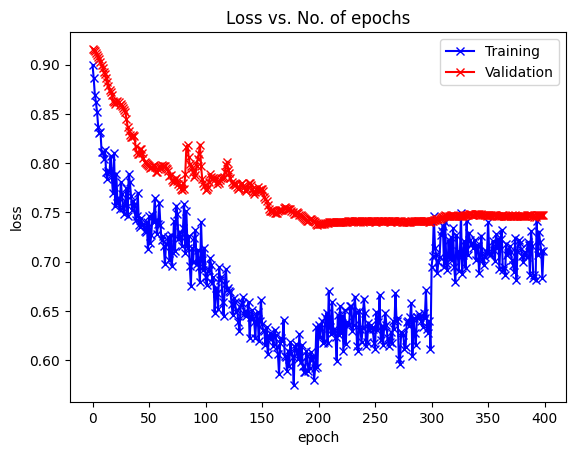

In [25]:
plot_losses(history)

In [26]:
def calculateIoU(gtMask, predMask):
    # Calculate the true positives,
    # false positives, and false negatives
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    #Check if the gtMask has any values
    if len(gtMask) == 0 or len(gtMask[0]) == 0:
        print("gtMask is empty")
        return 0.0
    for i in range(len(gtMask)):
        for j in range(len(gtMask[0])):
            if gtMask[i][j] == 1 and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                fn += 1
            else:
                tn += 1

    # Calculate IoU
    
    iou = tp / (tp + fp + fn + 1e-6)  # Adding a small value to avoid division by zero
    accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)  # Adding a small value to avoid division by zero


    return iou, accuracy

In [27]:
#Predict on the test set
def predict(model, test_loader):
    iou = []
    accuracy = []
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        # Calculate IoU for each class
        for i in range(len(outputs)):
            pred_mask = outputs[i]
            gt_mask = targets[i].cpu().numpy()
            temp_iou, temp_accuracy = calculateIoU(gt_mask, pred_mask)
            accuracy.append(temp_accuracy)
            iou.append(temp_iou)
    #Average IoU across all classes
    avg_iou = sum(iou) / len(iou)
    avg_accuracy = sum(accuracy) / len(accuracy)
    return avg_iou, avg_accuracy

In [28]:
iou, accuracy = predict(model, test_loader)

In [29]:
print("Average Accuracy:", accuracy)
print(f"Average IoU:", iou)

Average Accuracy: 0.9800591775495836
Average IoU: 0.27711353210400447


In [30]:
#Read the following text file to get training data: "Full data training.txt"

my_file = open("Full data training.txt", "r")
data = my_file.read()
#Data is in the format Epoch 1/200 - Train Loss: 0.9247 - Val Loss: 0.9153 
#I just need the train loss and val loss values
data = data.split("\n")
data = [line.split(" - ") for line in data if line.strip() != ""]

my_file.close()

In [31]:
#Remove non-numeric values from the data
for i in range(len(data)):
    data[i][0] = data[i][0].split(" ")[-1]
    data[i][1] = data[i][1].split(": ")[-1]
    data[i][2] = data[i][2].split(": ")[-1] 

In [32]:
print(data)

[['1/200', '0.9247', '0.9153'], ['2/200', '0.9159', '0.9144'], ['3/200', '0.9028', '0.9127'], ['4/200', '0.8993', '0.9113'], ['5/200', '0.8928', '0.9100'], ['6/200', '0.8873', '0.9078'], ['7/200', '0.8797', '0.9054'], ['8/200', '0.8750', '0.9027'], ['9/200', '0.8742', '0.9002'], ['10/200', '0.8621', '0.8975'], ['11/200', '0.8546', '0.8942'], ['12/200', '0.8614', '0.8916'], ['13/200', '0.8589', '0.8885'], ['14/200', '0.8707', '0.8872'], ['15/200', '0.8547', '0.8845'], ['16/200', '0.8493', '0.8812'], ['17/200', '0.8490', '0.8783'], ['18/200', '0.8419', '0.8757'], ['19/200', '0.8347', '0.8723'], ['20/200', '0.8577', '0.8711'], ['21/200', '0.8267', '0.8668'], ['22/200', '0.8376', '0.8643'], ['23/200', '0.8329', '0.8621'], ['24/200', '0.8292', '0.8605'], ['25/200', '0.8291', '0.8593'], ['26/200', '0.8293', '0.8566'], ['27/200', '0.8323', '0.8534'], ['28/200', '0.8132', '0.8496'], ['29/200', '0.8157', '0.8465'], ['30/200', '0.8161', '0.8448'], ['31/200', '0.8238', '0.8435'], ['32/200', '0.81

In [33]:
#Convert data in the same format as history
full_history = []
for i in range(len(data)):
    full_history.append({"train_loss": float(data[i][1]), "val_loss": float(data[i][2])})

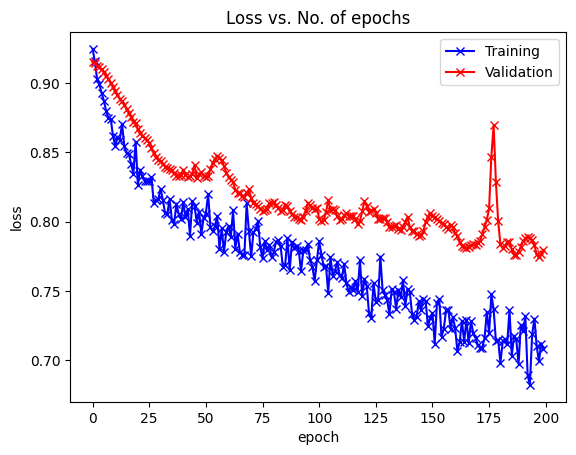

In [34]:
plot_losses(full_history)

In [35]:
def display_image_with_mask(image: torch.tensor, mask: np.ndarray, alpha: float = 0.5):
    """
    Display a grayscale image with a binary mask overlaid.

    Parameters:
    - image: 2D tensor for a scan
    - mask:  2D numpy array of same shape with binary values (0 or 1).
    - alpha: float transparency for mask overlay.
    """
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, alpha=alpha)
    plt.axis('off')
    plt.show()

In [36]:
# errors with: case133_day25_slice_0049, All of day 77
X, y = mrid["case133_day25_slice_0049"]
print(len(mrid))

display_image_with_mask(X.squeeze(), y)

X_pred = X.unsqueeze(0).to(device)
y_pred = model(X_pred)

y_pred = torch.argmax(y_pred, dim=1)

y_print = y_pred.detach().cpu().numpy()
display_image_with_mask(X.squeeze(), y_print.squeeze())

KeyError: 'case133_day25_slice_0049'